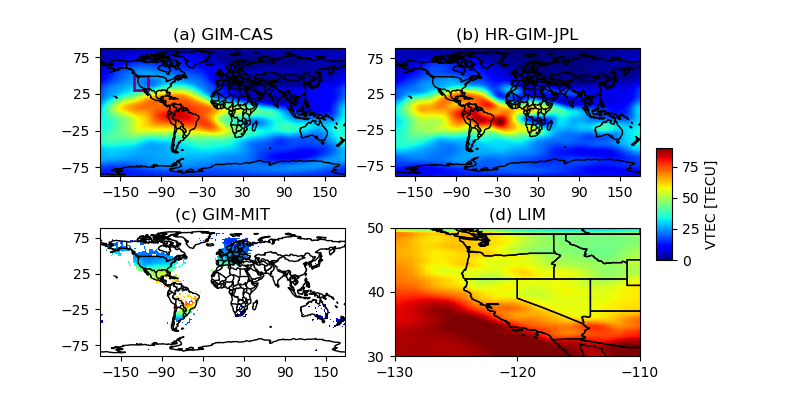

In [5]:
%matplotlib widget
from mintpy.objects import ionex
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import h5py
from matplotlib.patches import Rectangle

# 读取 IONEX 文件
tec_file = '/home/eedy/data/aux/IONEX/casg1250.23i'
mins, lat, lon, tec_maps, rms_maps = ionex.read_ionex(tec_file)

# 读取 hr-gim-JPL 文件
filename_nc = '/home/eedy/data/aux/IONEX/jpld1250.23i.nc'
dataset = Dataset(filename_nc, 'r')
lat_hr = dataset.variables['lat'][:]
lon_hr = dataset.variables['lon'][:]
tec_hr = dataset.variables['tecmap'][:]
dataset.close()

# 读取 netCDF 文件
filename_nc = '/home/eedy/data/aux/IONEX/gps230505g.001.hdf5'
dataset = Dataset(filename_nc, 'r')
lat_nc = dataset.variables['gdlat'][:]
lon_nc = dataset.variables['glon'][:]
tec_nc = dataset.variables['tec'][:]
dataset.close()
utc_min = np.arange(0, 24 * 60, 5)

# 读取 LIM 文件
filename_lim = '/home/eedy/data/aux/LIM/USA/USA_TEC_10M_20231390.GIM.h5'

def read_LIM_file(filename):
    with h5py.File(filename, 'r') as f:
        tec_maps = f['GIM_all'][:]
        tec_dx = f['GIX_x_all'][:]
        tec_dy = f['GIX_y_all'][:]

    # 交换维度顺序，从 (lons, lats, mins) 变为 (mins, lats, lons)
    tec_maps = np.transpose(tec_maps, (2, 1, 0))
    tec_dx = np.transpose(tec_dx, (2, 1, 0))
    tec_dy = np.transpose(tec_dy, (2, 1, 0))

    # 定义经纬度和时间间隔
    lon = np.arange(-130, -110 + 0.5, 0.5)
    lat = np.arange(30, 50 + 0.25, 0.25)
    mins = np.arange(1140,  1140 + 120 , 10)

    return lat, lon, mins, tec_maps, tec_dx, tec_dy

lat_lim, lon_lim, mins_lim, tec_maps_lim, tec_maps_dx_lim, tec_maps_dy_lim = read_LIM_file(filename_lim)

cmap = 'jet'
# 创建带有4个子图的图形
fig, axes = plt.subplots(2, 2, figsize=(8, 4), 
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'hspace': 0.4, 'wspace': 0.2})

# 绘制第一个子图 
ax = axes[0,0]
im1 = ax.imshow(tec_maps[38], cmap=cmap, origin='lower',
               extent=[lon.min(), lon.max(), lat.min(), lat.max()],
               transform=ccrs.PlateCarree(), vmin=0, vmax=90, aspect='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_xticks(np.arange(-150, 151, 60))
ax.set_yticks(np.arange(-75, 76, 50))
ax.set_title('(a) GIM-CAS')
# 在第一个子图上绘制矩形框
rect = Rectangle((-130, 30), -110 - (-130), 50 - 30, linewidth=2, edgecolor='purple', facecolor='none', transform=ccrs.PlateCarree())
ax.add_patch(rect)

# 绘制第二个子图 
ax = axes[0,1]
im2 = ax.imshow(tec_hr[76], cmap=cmap, origin='lower',
               extent=[lon_nc.min(), lon_nc.max(), lat_nc.min(), lat_nc.max()],
               transform=ccrs.PlateCarree(), vmin=0, vmax=90, aspect='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_xticks(np.arange(-150, 151, 60))
ax.set_yticks(np.arange(-75, 76, 50))
ax.set_title('(b) HR-GIM-JPL')

# 绘制第三个子图 
ax = axes[1,0]
im3 = ax.imshow(tec_nc[228], cmap=cmap, origin='lower',
               extent=[lon_nc.min(), lon_nc.max(), lat_nc.min(), lat_nc.max()],
               transform=ccrs.PlateCarree(), vmin=0, vmax=90, aspect='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_xticks(np.arange(-150, 151, 60))
ax.set_yticks(np.arange(-75, 76, 50))
ax.set_title('(c) GIM-MIT')

# 绘制第四个子图 
ax = axes[1,1]
im4 = ax.imshow(tec_maps_lim[0,:,:], cmap=cmap, origin='lower',
               extent=[-130,-110,30,50],
               transform=ccrs.PlateCarree(), vmin=0, vmax=90, aspect='auto')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.set_xticks(np.arange(-130, -109, 10))
ax.set_yticks(np.arange(30, 51, 10))
ax.set_title('(d) LIM')

# 调整布局以给颜色条留出空间
fig.subplots_adjust(right=0.8)

# 在整个图形的右边添加颜色条
cbar_ax = fig.add_axes([0.82, 0.35, 0.02, 0.28])
fig.colorbar(im1, cax=cbar_ax, label='VTEC [TECU]')

# 调整布局并保存
plt.savefig('pdf/iono_map.pdf', bbox_inches='tight', transparent=True, dpi=600)
plt.show()